In [1]:
%load_ext autoreload
%autoreload 2
import glob
import numpy as np
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm, trange
from sglm.models import sglm
from sglm.features import gen_signal_df as gsd
from sglm.features import build_features as bf
from sglm.features import gen_signal_df as gsd
from sglm.features import build_features as bf

import itertools

signal_files = []


In [2]:

y_col_lst_all = ['gACH', 'rDA', 'gDA',              
                 'gACH_flx_drd', 'rDA_flx_drd', 'gDA_flx_drd',
                 'gACH_flx_cht', 'rDA_flx_cht', 'gDA_flx_cht',
                 'gACH_flx_drdcht', 'rDA_flx_drdcht', 'gDA_flx_drdcht',
                 'Ch5', 'Ch6', 'GP_1', 'GP_2', 'GP_5', 'GP_6', 'SGP_1', 'SGP_2', 'SGP_5', 'SGP_6']


In [3]:
# ### Figure 1: Single side recording
figure = 'fig1'

# # Load Signal Data

# signal_files = glob.glob(f'../../data/raw/GLM_SIGNALS_WT61_*')
# signal_files += glob.glob(f'../../data/raw/GLM_SIGNALS_WT63_*')
# signal_files += glob.glob(f'../../data/raw/GLM_SIGNALS_WT64_*')

# ignore_files = [
#                 'WT61_10152021',
#                 'WT61_10082021'
#                 ]
# for ign in ignore_files:
#     signal_files = [_ for _ in signal_files if ign not in _]

# table_files = [_.replace('GLM_SIGNALS', 'GLM_TABLE') for _ in signal_files]

# channel_definitions = {
#         ('WT61',): {'Ch1': 'gACH', 'Ch2': 'rDA'},
#         ('WT64',): {'Ch1': 'gACH', 'Ch2': 'empty'},
#         ('WT63',): {'Ch1': 'gDA', 'Ch2': 'empty'},
#     }

group_1_mice = ['WT63', 'WT64', 'WT65']
group_1_sess = ['11082021', '11102021', '11122021', '11182021']
group_1_combo = ['_'.join(_) for _ in list(itertools.product(group_1_mice, group_1_sess))]

group_2_mice = ['WT66', 'WT67', 'WT68', 'WT69']
group_2_sess = ['12132021', '12152021', '12172021', '12192021']
group_2_combo = ['_'.join(_) for _ in list(itertools.product(group_2_mice, group_2_sess))]

group_3_mice = ['WT58', 'WT60', 'WT61']
group_3_sess = ['10042021', '10062021', '10082021', '10112021', '10132021', '10152021']
group_3_combo = ['_'.join(_) for _ in list(itertools.product(group_3_mice, group_3_sess))]

group_4_mice = ['WT53', 'WT54', 'WT55', 'WT56']
group_4_sess = ['09012021', '09032021', '09062021']
group_4_combo = ['_'.join(_) for _ in list(itertools.product(group_4_mice, group_4_sess))]

group_5_mice = ['WT57', 'WT59']
group_5_sess = ['10042021', '10062021', '10082021', '10112021', '10132021', '10152021']
group_5_combo = ['_'.join(_) for _ in list(itertools.product(group_5_mice, group_5_sess))]

group_6_mice = ['WT62']
group_6_sess = ['11082021', '11102021', '11122021', '11182021']
group_6_combo = ['_'.join(_) for _ in list(itertools.product(group_6_mice, group_6_sess))]


channel_definitions = {}
# channel_definitions = {(file_combo,): {'Ch1': 'gACH', 'Ch2': 'rDA'} for file_combo in group_1_combo}
channel_definitions.update({(file_combo,): {'Ch1': 'gDA', 'Ch5': 'gACH'} for file_combo in group_1_combo})
channel_definitions.update({(file_combo,): {'Ch1': 'gDA'} for file_combo in group_2_combo})
channel_definitions.update({(file_combo,): {'Ch1': 'gACH'} for file_combo in group_3_combo})
channel_definitions.update({(file_combo,): {'Ch1': 'gACH'} for file_combo in group_4_combo})
channel_definitions.update({(file_combo,): {'Ch5': 'gACH'} for file_combo in group_5_combo})
channel_definitions.update({(file_combo,): {'Ch1': 'gDA'} for file_combo in group_6_combo})




fig_1_signal_files_setup = group_1_combo + group_2_combo + group_3_combo + group_4_combo + group_5_combo + group_6_combo

for f in fig_1_signal_files_setup:
    glob_file = glob.glob(f'../../data/raw/{figure}/GLM_SIGNALS_{f}*')
    if len(glob_file) != 1:
        print('Missing file!!! ', f)
    signal_files += glob_file

Missing file!!!  WT63_11082021
Missing file!!!  WT56_09062021
Missing file!!!  WT59_10062021


In [4]:
### Figure 2: Dual side recording
figure = 'fig2'

# 'WT61', 'WT63', 'WT64', '', 'WT44', 'WT51' # Excluding 'WT43

# ['03162021','03192021','03232021','03262021','07282021','07302021','08012021', '08042021', '08062021', '08102021', '10042021',
# '10082021', '10112021', '10132021', '10182021', '11082021', '11102021', '11122021', '11162021', '11182021']


group_1_mice = ['WT61', 'WT63', 'WT64', 'WT44', 'WT51']
group_1_sess = ['03162021','03192021','03232021','03262021','07282021','07302021','08012021', '08042021', '08062021', '08102021', '10042021',
                '10082021', '10112021', '10132021', '10182021', '11082021', '11102021', '11122021', '11162021', '11182021']
group_1_combo = ['_'.join(_) for _ in list(itertools.product(group_1_mice, group_1_sess))]

# group_2_mice = ['WT66', 'WT67', 'WT68', 'WT69']
# group_2_sess = ['12132021', '12152021', '12172021', '12192021']
# group_2_combo = ['_'.join(_) for _ in list(itertools.product(group_2_mice, group_2_sess))]

# group_3_mice = ['WT58', 'WT60', 'WT61']
# group_3_sess = ['10042021', '10062021', '10082021', '10112021', '10132021', '10152021']
# group_3_combo = ['_'.join(_) for _ in list(itertools.product(group_3_mice, group_3_sess))]

# group_4_mice = ['WT53', 'WT54', 'WT55', 'WT56']
# group_4_sess = ['09012021', '09032021', '09062021']
# group_4_combo = ['_'.join(_) for _ in list(itertools.product(group_4_mice, group_4_sess))]

# group_5_mice = ['WT61']
# group_5_sess = ['10042021', '10062021', '10082021', '10112021', '10132021', '10152021']
# group_5_combo = ['_'.join(_) for _ in list(itertools.product(group_5_mice, group_5_sess))]

group_6_mice = ['WT43']
group_6_sess = []
group_6_combo = ['_'.join(_) for _ in list(itertools.product(group_6_mice, group_6_sess))]


channel_definitions = {}
# channel_definitions = {(file_combo,): {'Ch1': 'gACH', 'Ch2': 'rDA'} for file_combo in group_1_combo}
channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA'} for file_combo in group_1_combo})
# channel_definitions.update({(file_combo,): {'Ch1': 'gDA'} for file_combo in group_2_combo})
# channel_definitions.update({(file_combo,): {'Ch1': 'gACH'} for file_combo in group_3_combo})
# channel_definitions.update({(file_combo,): {'Ch1': 'gACH'} for file_combo in group_4_combo})
# channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA'} for file_combo in group_5_combo})
channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA'} for file_combo in group_6_combo})


fig_2_signal_files_setup = group_1_combo #+ group_2_combo + group_3_combo + group_4_combo + group_5_combo + group_6_combo
for f in fig_2_signal_files_setup:
    glob_file = glob.glob(f'../../data/raw/{figure}/GLM_SIGNALS_{f}*')
    if len(glob_file) != 1:
        print('Missing file!!! ', f)
    signal_files += glob_file



Missing file!!!  WT61_03162021
Missing file!!!  WT61_03192021
Missing file!!!  WT61_03232021
Missing file!!!  WT61_03262021
Missing file!!!  WT61_07282021
Missing file!!!  WT61_07302021
Missing file!!!  WT61_08012021
Missing file!!!  WT61_08042021
Missing file!!!  WT61_08062021
Missing file!!!  WT61_08102021
Missing file!!!  WT61_11082021
Missing file!!!  WT61_11102021
Missing file!!!  WT61_11122021
Missing file!!!  WT61_11162021
Missing file!!!  WT61_11182021
Missing file!!!  WT63_03162021
Missing file!!!  WT63_03192021
Missing file!!!  WT63_03232021
Missing file!!!  WT63_03262021
Missing file!!!  WT63_07282021
Missing file!!!  WT63_07302021
Missing file!!!  WT63_08012021
Missing file!!!  WT63_08042021
Missing file!!!  WT63_08062021
Missing file!!!  WT63_08102021
Missing file!!!  WT63_10042021
Missing file!!!  WT63_10082021
Missing file!!!  WT63_10112021
Missing file!!!  WT63_10132021
Missing file!!!  WT63_10182021
Missing file!!!  WT64_03162021
Missing file!!!  WT64_03192021
Missing 

In [5]:
### Figure 3: Flox Mice
figure = 'fig3'

# Drd2f/f control: S1417, 1419, 1421
group_1_mice = ['S1417', 'S1419', 'S1421']
group_1_sess = ['03172022', '03212022', '03232022', '03252022', '03292022', '03312022', '04032022', '04052022',
                '04072022', '04082022', '04112022', '04132022', '04152022', '04202022', '04222022', '05022022',
                '05102022', '05162022', '05182022', '05222022', '05232022', '05242022', '05252022', '05262022',
                '05272022', '05292022', '05302022', '05312022']
group_1_combo = ['_'.join(_) for _ in list(itertools.product(group_1_mice, group_1_sess))]

# Chat Cre X Drd2f/f: S1416, 1418, 1420, 1422
group_2_mice = ['S1416', 'S1418', 'S1420', 'S1422']
group_2_sess = ['03172022', '03212022', '03232022', '03252022', '03292022', '03312022', '04032022', '04052022',
                '04072022', '04082022', '04112022', '04132022', '04152022', '04202022', '04222022', '05022022',
                '05102022', '05162022', '05182022', '05222022', '05232022', '05242022', '05252022', '05262022',
                '05272022', '05292022', '05302022', '05312022']
group_2_combo = ['_'.join(_) for _ in list(itertools.product(group_2_mice, group_2_sess))]

# Chat Cre control: S1355-1358, S1374, S1376
group_3_mice = ['S1355', 'S1356', 'S1357', 'S1358', 'S1374', 'S1376']
group_3_sess = ['03172022', '03212022', '03232022', '03252022', '03292022', '03312022', '04032022', '04052022',
                '04072022', '04082022', '04112022', '04132022', '04152022', '04202022', '04222022', '05022022',
                '05102022', '05162022', '05182022', '05222022', '05232022', '05242022', '05252022', '05262022',
                '05272022', '05292022', '05302022', '05312022']
group_3_combo = ['_'.join(_) for _ in list(itertools.product(group_3_mice, group_3_sess))]

# Chat Cre control: S1399-1401
group_4_mice = ['S1399', 'S1400', 'S1401']
group_4_sess = ['03172022', '03212022', '03232022', '03252022', '03292022', '03312022', '04032022', '04052022',
                '04072022', '04082022', '04112022', '04132022', '04152022', '04202022', '04222022', '05022022',
                '05102022', '05162022', '05182022', '05222022', '05232022', '05242022', '05252022', '05262022',
                '05272022', '05292022', '05302022', '05312022']
group_4_combo = ['_'.join(_) for _ in list(itertools.product(group_4_mice, group_4_sess))]

group_5_mice = []
group_5_sess = []
group_5_combo = ['_'.join(_) for _ in list(itertools.product(group_5_mice, group_5_sess))]

group_6_mice = []
group_6_sess = []
group_6_combo = ['_'.join(_) for _ in list(itertools.product(group_6_mice, group_6_sess))]


channel_definitions = {}
# channel_definitions = {(file_combo,): {'Ch1': 'gACH', 'Ch2': 'rDA'} for file_combo in group_1_combo}
channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA', 'Ch1':'gDA'} for file_combo in group_1_combo})
channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA', 'Ch1':'gDA'} for file_combo in group_2_combo})
channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA', 'Ch1':'gDA'} for file_combo in group_3_combo})
channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA'} for file_combo in group_4_combo})
# channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA'} for file_combo in group_5_combo})
channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA'} for file_combo in group_6_combo})


out_files = {}

fig_3_signal_files_setup = [group_1_combo, group_2_combo, group_3_combo, group_4_combo, group_5_combo, group_6_combo]
for g_num in range(0, len(fig_3_signal_files_setup)):
    fig_3_basis = fig_3_signal_files_setup[g_num]
    for f in fig_3_basis:
        glob_file = glob.glob(f'../../data/raw/{figure}/GLM_SIGNALS_{f}*')
        if len(glob_file) != 1:
            print('Missing file!!! ', f)
        else:
            signal_files += glob_file
            out_files[glob_file[0]] = (figure, figure + '/g' + str(g_num+1))



Missing file!!!  S1417_03172022
Missing file!!!  S1417_03212022
Missing file!!!  S1417_03232022
Missing file!!!  S1417_03252022
Missing file!!!  S1417_03292022
Missing file!!!  S1417_03312022
Missing file!!!  S1417_04032022
Missing file!!!  S1417_04052022
Missing file!!!  S1417_04072022
Missing file!!!  S1417_04082022
Missing file!!!  S1417_04112022
Missing file!!!  S1417_04132022
Missing file!!!  S1417_04152022
Missing file!!!  S1417_04202022
Missing file!!!  S1417_04222022
Missing file!!!  S1417_05022022
Missing file!!!  S1417_05102022
Missing file!!!  S1417_05162022
Missing file!!!  S1417_05182022
Missing file!!!  S1417_05222022
Missing file!!!  S1417_05242022
Missing file!!!  S1417_05252022
Missing file!!!  S1417_05262022
Missing file!!!  S1417_05292022
Missing file!!!  S1417_05312022
Missing file!!!  S1419_03172022
Missing file!!!  S1419_03212022
Missing file!!!  S1419_03232022
Missing file!!!  S1419_03252022
Missing file!!!  S1419_03292022
Missing file!!!  S1419_03312022
Missing 

In [6]:
### Figure 2 dualhem
figure = 'fig2-dualhem'

group_1_mice = ['WT62', 'WT63', 'WT64', 'WT65']
group_1_sess = ['10042021', '10082021', '10112021', '10132021',
                '10182021', '11082021', '11102021', '11122021', '11162021', '11182021']
group_1_combo = ['_'.join(_) for _ in list(itertools.product(group_1_mice, group_1_sess))]

group_2_mice = []
group_2_sess = []
group_2_combo = ['_'.join(_) for _ in list(itertools.product(group_2_mice, group_2_sess))]

group_3_mice = []
group_3_sess = []
group_3_combo = ['_'.join(_) for _ in list(itertools.product(group_3_mice, group_3_sess))]

group_4_mice = []
group_4_sess = []
group_4_combo = ['_'.join(_) for _ in list(itertools.product(group_4_mice, group_4_sess))]

group_5_mice = []
group_5_sess = []
group_5_combo = ['_'.join(_) for _ in list(itertools.product(group_5_mice, group_5_sess))]

group_6_mice = []
group_6_sess = []
group_6_combo = ['_'.join(_) for _ in list(itertools.product(group_6_mice, group_6_sess))]


channel_definitions = {}
# channel_definitions = {(file_combo,): {'Ch1': 'gACH', 'Ch2': 'rDA'} for file_combo in group_1_combo}
channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA', 'Ch1':'gDA'} for file_combo in group_1_combo})
channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA', 'Ch1':'gDA'} for file_combo in group_2_combo})
channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA', 'Ch1':'gDA'} for file_combo in group_3_combo})
channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA'} for file_combo in group_4_combo})
channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA'} for file_combo in group_5_combo})
channel_definitions.update({(file_combo,): {'Ch5': 'gACH', 'Ch6': 'rDA'} for file_combo in group_6_combo})


fig_2dh_signal_files_setup = [group_1_combo, group_2_combo, group_3_combo, group_4_combo, group_5_combo, group_6_combo]
for g_num in range(0, len(fig_2dh_signal_files_setup)):
    fig_2dh_basis = fig_2dh_signal_files_setup[g_num]
    for f in fig_2dh_basis:
        glob_file = glob.glob(f'../../data/raw/{figure}/GLM_SIGNALS_{f}*')
        if len(glob_file) != 1:
            print('Missing file!!! ', f)
        else:
            signal_files += glob_file


Missing file!!!  WT62_10042021
Missing file!!!  WT62_10082021
Missing file!!!  WT62_10112021
Missing file!!!  WT62_10132021
Missing file!!!  WT62_10182021
Missing file!!!  WT62_11162021
Missing file!!!  WT63_10042021
Missing file!!!  WT63_10082021
Missing file!!!  WT63_10112021
Missing file!!!  WT63_10132021
Missing file!!!  WT63_10182021
Missing file!!!  WT63_11082021
Missing file!!!  WT64_10042021
Missing file!!!  WT64_10082021
Missing file!!!  WT64_10112021
Missing file!!!  WT64_10132021
Missing file!!!  WT64_10182021
Missing file!!!  WT65_10042021
Missing file!!!  WT65_10082021
Missing file!!!  WT65_10112021
Missing file!!!  WT65_10132021
Missing file!!!  WT65_10182021


In [7]:
# import glob
# figure = 'fig2-dualhem'
# print(sorted(list(set([_.split('_')[-1].replace('.txt', '') for _ in glob.glob(f'../../data/raw/{figure}/GLM_SIGNALS_*') if 'WT6' in _]))))

In [8]:
# figure = 'fig3'
# print(sorted(list(set([_.split('_')[-1].replace('.txt', '') for _ in glob.glob(f'../../data/raw/{figure}/GLM_SIGNALS_*')]))))

In [9]:
ignore_files = [
                'WT61_10152021',
                'WT61_10082021'
                ]
for ign in ignore_files:
    signal_files = [_ for _ in signal_files if ign not in _]

table_files = [_.replace('GLM_SIGNALS', 'GLM_TABLE') for _ in signal_files]


channel_assignments = bf.get_rename_columns_by_file(signal_files, channel_definitions)

for file_num in trange(len(signal_files)):

    ## Load Table Data
    # signal_fn = signal_files[0]
    # table_fn = table_files[0]

    signal_path = signal_files[file_num]
    table_path = table_files[file_num]

    signal_fn = signal_files[file_num].split('/')[-1]
    table_fn = table_files[file_num].split('/')[-1]

    signal_filename_out = signal_fn.replace('GLM_SIGNALS', 'GLM_SIGNALS_INTERIM').replace('txt', 'csv')
    table_filename_out = table_fn.replace('GLM_TABLE', 'GLM_TABLE_INTERIM').replace('txt', 'csv')

    # signal_path_out = f'../../data/interim/{signal_filename_out}'
    # table_path_out = f'../../data/interim/{table_filename_out}'

    signal_path_out = signal_path.replace(r'/raw/', r'/interim/').replace('GLM_SIGNALS', 'GLM_SIGNALS_INTERIM').replace('txt', 'csv')
    table_path_out = table_path.replace(r'/raw/', r'/interim/').replace('GLM_SIGNALS', 'GLM_SIGNALS_INTERIM').replace('txt', 'csv')

    if signal_path in out_files:
        signal_path_out = signal_path_out.replace(*out_files[signal_path])
        table_path_out = table_path_out.replace(*out_files[signal_path])

    signal_df = pd.read_csv(signal_path)
    table_df = pd.read_csv(table_path)

    signal_df, table_df = gsd.generate_signal_df(signal_path,
                                            table_path,
                                            # signal_filename_out=f'../../data/interim/{signal_filename_out}',
                                            # table_filename_out=f'../../data/interim/{table_filename_out}'
                                            )

    signal_df = signal_df[signal_df['nTrial'] > 0].fillna(0)

    # Break down Preprocess Lynne into component parts

    # Rename Columns
    signal_df = bf.rename_consistent_columns(signal_df)

    for y_col in y_col_lst_all:
        if y_col not in signal_df.columns:
            signal_df[y_col] = np.nan
            continue

    # print(channel_assignments.keys())
    # print(signal_fn)
    if signal_fn in channel_assignments:
        signal_df = signal_df.rename(channel_assignments[signal_fn], axis=1)

    ## Set Full Trial Reward Flags
    signal_df['r_trial'] = (signal_df.groupby('nTrial')['photometrySideInIndexr'].transform(np.sum) > 0) * 1.0
    signal_df['nr_trial'] = (signal_df.groupby('nTrial')['photometrySideInIndexnr'].transform(np.sum) > 0) * 1.0

    ## Define Side Rewarded / Unrewarded Flags
    signal_df = bf.set_port_entry_exit_rewarded_unrewarded_indicators(signal_df)

    ## Define Side Agnostic Events
    signal_df = bf.define_side_agnostic_events(signal_df)

    # print('Percent of Data in ITI:', (df['nTrial'] == df['nEndTrial']).mean())

    signal_df['spnrOff'] = ((signal_df['spnr'] == 1)&(signal_df['photometrySideInIndex'] != 1)).astype(int)
    signal_df['spxrOff'] = ((signal_df['spxr'] == 1)&(signal_df['photometrySideOutIndex'] != 1)).astype(int)
    spnnrOff_a = ((signal_df['spnnr'] == 1)&(signal_df['photometrySideInIndex'] != 1)).astype(int)
    spxnrOff_a = ((signal_df['spxnr'] == 1)&(signal_df['photometrySideOutIndex'] != 1)).astype(int)

    # If we have something listed as a rewarded "off" side entry labeled in the table as a side exit... it means it was a fast "out-in".
    # The latter "in" should be considered an unrewarded side port "off" entry.
    dualism_exen = ((signal_df['spnrOff'] == 1)&(signal_df['photometrySideOutIndex'] == 1)).astype(int)

    # Unrewarded side port entries should be the combination of those simply identified by checking spnnr & the table labels +
    # the dualism defined immediately prior. Then those dualism examples should be remoed from the "off" rewarded entries.
    signal_df['spnnrOff'] = spnnrOff_a + dualism_exen
    signal_df['spnrOff'] = signal_df['spnrOff'] - dualism_exen

    signal_df['spxnrOff'] = spxnrOff_a

    

    signal_df['slOff'] = signal_df['sl'] * signal_df['nr_trial']
    signal_df['slOn'] = signal_df['sl'] - signal_df['slOff']


    
    signal_df['cpnOff'] = ((signal_df['cpn'] == 1)&(signal_df['photometryCenterInIndex'] != 1)).astype(int)
    signal_df['cpxOff'] = ((signal_df['cpx'] == 1)&(signal_df['photometryCenterOutIndex'] != 1)).astype(int)
    # spnnrOff_a = ((signal_df['cpnOff'] == 1)&(signal_df['photometryCenterInIndex'] != 1)).astype(int)
    # spxnrOff_a = ((signal_df['cpxOff'] == 1)&(signal_df['photometryCenterOutIndex'] != 1)).astype(int)

    # # If we have something listed as a rewarded "off" side entry labeled in the table as a side exit... it means it was a fast "out-in".
    # # The latter "in" should be considered an unrewarded side port "off" entry.
    # dualism_exen = ((signal_df['cpnOff'] == 1)&(signal_df['photometryCenterOutIndex'] == 1)).astype(int)

    # # Unrewarded side port entries should be the combination of those simply identified by checking spnnr & the table labels +
    # # the dualism defined immediately prior. Then those dualism examples should be remoed from the "off" rewarded entries.
    # signal_df['spnnrOff'] = spnnrOff_a + dualism_exen
    # signal_df['spnrOff'] = signal_df['spnrOff'] - dualism_exen

    # signal_df['spxnrOff'] = spxnrOff_a

    if signal_path_out:
        signal_df.to_csv(signal_path_out, index_label='index')
    if table_path_out:
        table_df.to_csv(table_path_out, index_label='index')
    



('WT62_10042021',)
('WT62_10082021',)
('WT62_10112021',)
('WT62_10132021',)
('WT62_10182021',)
('WT62_11082021',)
> GLM_SIGNALS_WT62_11082021.txt
> GLM_SIGNALS_WT62_11082021.txt
('WT62_11102021',)
> GLM_SIGNALS_WT62_11102021.txt
> GLM_SIGNALS_WT62_11102021.txt
('WT62_11122021',)
> GLM_SIGNALS_WT62_11122021.txt
> GLM_SIGNALS_WT62_11122021.txt
('WT62_11162021',)
('WT62_11182021',)
> GLM_SIGNALS_WT62_11182021.txt
> GLM_SIGNALS_WT62_11182021.txt
('WT63_10042021',)
('WT63_10082021',)
('WT63_10112021',)
('WT63_10132021',)
('WT63_10182021',)
('WT63_11082021',)
> GLM_SIGNALS_WT63_11082021.txt
('WT63_11102021',)
> GLM_SIGNALS_WT63_11102021.txt
> GLM_SIGNALS_WT63_11102021.txt
> GLM_SIGNALS_WT63_11102021.txt
('WT63_11122021',)
> GLM_SIGNALS_WT63_11122021.txt
> GLM_SIGNALS_WT63_11122021.txt
> GLM_SIGNALS_WT63_11122021.txt
('WT63_11162021',)
> GLM_SIGNALS_WT63_11162021.txt
> GLM_SIGNALS_WT63_11162021.txt
('WT63_11182021',)
> GLM_SIGNALS_WT63_11182021.txt
> GLM_SIGNALS_WT63_11182021.txt
> GLM_SIGNAL

# of iterations 0 — Final max amount of duplicated Center Out Indices: 1
# of iterations 0 — Final max amount of duplicated Center Out Indices: 1
# of iterations 0 — Final max amount of duplicated Center Out Indices: 1
# of iterations 0 — Final max amount of duplicated Center Out Indices: 1
# of iterations 0 — Final max amount of duplicated Center Out Indices: 1
# of iterations 0 — Final max amount of duplicated Center Out Indices: 1
# of iterations 0 — Final max amount of duplicated Center Out Indices: 1
# of iterations 0 — Final max amount of duplicated Center Out Indices: 1
# of iterations 0 — Final max amount of duplicated Center Out Indices: 1
# of iterations 0 — Final max amount of duplicated Center Out Indices: 1
# of iterations 0 — Final max amount of duplicated Center Out Indices: 1
# of iterations 0 — Final max amount of duplicated Center Out Indices: 1
# of iterations 0 — Final max amount of duplicated Center Out Indices: 1
# of iterations 0 — Final max amount of duplicated 

,gDA,Ch2,gACH,rDA,cpo,cpn,cpx,rpo,rpn,rpx,...,spxnr,sl,spnrOff,spxrOff,spnnrOff,spxnrOff,slOff,slOn,cpnOff,cpxOff


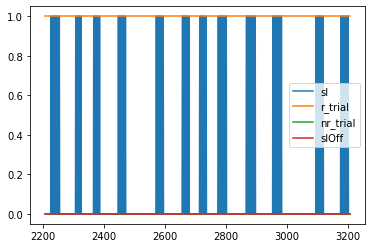

In [10]:
signal_df[['sl', 'r_trial', 'nr_trial', 'slOff', ]].iloc[1000:2000].plot()
signal_df[signal_df['r_trial'] == signal_df['nr_trial']]

In [11]:
# signal_df.columns

In [12]:
# a = signal_df.groupby('nTrial')['slOff'].sum()
# a[a > 0]

In [13]:
# # df['spnnr'] = ((df['spnnr'] == 1)&(df['photometrySideInIndex'] != 1)).astype(int)
# # df['spxnr'] = ((df['spxnr'] == 1)&(df['photometrySideOutIndex'] != 1)).astype(int)

# X_cols = [_ for _ in X_cols_all if _ not in left_out]

# if len(leave_one_out_list) > 1:
#     run_id = f'{prefix}_{fn}_{y_col}_drop={"_".join(left_out)}'
# else:
#     run_id = f'{prefix}_{fn}_{y_col}'

# dfrel = df.copy()

# dfrel, X_cols_sftd = lpp.timeshift_vals(dfrel, X_cols, neg_order=neg_order, pos_order=pos_order)

# dfrel_setup, dfrel_holdout = holdout_splits(dfrel,
#                                             id_cols=['nTrial'],
#                                             perc_holdout=pholdout)
# dfrel_setup, dfrel_holdout = dfrel_setup.copy(), dfrel_holdout.copy()

# kfold_cv_idx = sglm_ez.cv_idx_by_trial_id(dfrel_setup,
#                                           trial_id_columns=['nTrial'],
#                                           num_folds=folds,
#                                           test_size=pgss)

# prediction_X_cols = [_ for _ in X_cols if _ not in ['nTrial']]
# prediction_X_cols_sftd = [_ for _ in X_cols_sftd if _ not in ['nTrial']]

# X_setup = get_x(dfrel_setup, prediction_X_cols_sftd, keep_rows=None)
# y_setup = get_y(dfrel_setup, y_col, keep_rows=None)
# X_setup_noiti = get_x(dfrel_setup, prediction_X_cols_sftd, keep_rows=dfrel_setup['wi_trial_keep'])
# y_setup_noiti = get_y(dfrel_setup, y_col, keep_rows=dfrel_setup['wi_trial_keep'])
# best_score, best_score_std, best_params, best_model, cv_results = sglm_ez.simple_cv_fit(X_setup, y_setup, kfold_cv_idx, glm_kwarg_lst, model_type='Normal', verbose=0, score_method=score_method)

# sglm_ez.print_best_model_info(X_setup, best_score, best_params, best_model, start)

# X_holdout_witi = get_x(dfrel_holdout, prediction_X_cols_sftd, keep_rows=None)
# y_holdout_witi = get_y(dfrel_holdout, y_col, keep_rows=None)
# X_holdout_noiti = get_x(dfrel_holdout, prediction_X_cols_sftd, keep_rows=dfrel_holdout['wi_trial_keep'])
# y_holdout_noiti = get_y(dfrel_holdout, y_col, keep_rows=dfrel_holdout['wi_trial_keep'])
# glm, holdout_score, holdout_neg_mse_score = sglm_ez.training_fit_holdout_score(X_setup, y_setup, X_holdout_noiti, y_holdout_noiti, best_params)

# dfrel['pred'] = glm.predict(dfrel[prediction_X_cols_sftd])
# dfrel_setup['pred'] = glm.predict(dfrel_setup[prediction_X_cols_sftd])
# dfrel_holdout['pred'] = glm.predict(dfrel_holdout[prediction_X_cols_sftd])

# # Collect
# results_dict[f'{run_id}'] = {'holdout_score':holdout_score,
#                             'holdout_neg_mse_score':holdout_neg_mse_score,
#                             'best_score':best_score,
#                             'best_params':best_params,
#                             'all_models':sorted([(_['cv_R2_score'],
#                                                     _['cv_mse_score'],
#                                                     sglm_ez.calc_l1(_['cv_coefs']),
#                                                     sglm_ez.calc_l2(_['cv_coefs']),
#                                                     _['glm_kwargs']) for _ in cv_results['full_cv_results']], key=lambda x: -x[0])
#                             }

# X_cols_plot = prediction_X_cols
# X_cols_sftd_plot = prediction_X_cols_sftd

# # print('X_setup.columns', list(X_setup.columns), len(list(X_setup.columns)))
# # print('X_setup_noiti.columns', list(X_setup_noiti.columns), len(list(X_setup_noiti.columns)))
# # print('X_holdout_witi.columns', list(X_holdout_witi.columns), len(list(X_holdout_witi.columns)))
# # print('X_holdout_noiti.columns', list(X_holdout_noiti.columns), len(list(X_holdout_noiti.columns)))


# holdout_score_rnd = np.round(holdout_score, 4)
# best_beta_fn = f'{best_coeffs_folder}/{run_id}_best_{all_betas_basename}_R2_{holdout_score_rnd}.png'
# splt.plot_all_beta_coefs(glm.coef_, X_cols_plot,
#                                 X_cols_sftd_plot,
#                                 plot_width=4,
#                                 # plot_width=2,
#                                 y_lims=(-2.5, 2.5),
#                                 # filename=f'{fn}_coeffs.png',
#                                 binsize=54,
#                                 filename=best_beta_fn,
#                                 plot_name=f'Best Coeffs - {run_id} — {best_params}'
#                                 )

# best_beta_fn = f'{best_reconstruct_folder}/{run_id}_best_{avg_reconstruct_basename}_R2_{holdout_score_rnd}.png'




# splt.plot_avg_reconstructions_v2(dfrel_holdout,
# # splt.plot_avg_reconstructions_v2(dfrel,
#                             channel=y_col,
#                             binsize = 54,
#                             plot_width=4,
#                             min_time = -20,
#                             max_time = 30,
#                             min_signal = -3.0,
#                             max_signal = 3.0,
#                             file_name=best_beta_fn,
#                             title=f'Best Average Reconstruction - {run_id} — {best_params}'
#                             )

# for fitted_model_dict in (cv_results['full_cv_results']):
#     fitted_model = fitted_model_dict['model']
#     kwarg_info = "_".join([f"{_k}_{fitted_model_dict['glm_kwargs'][_k]}" for _k in fitted_model_dict["glm_kwargs"]])

#     model_coef = fitted_model.coef_
#     model_intercept = fitted_model.intercept_

#     std_name = f'{run_id}_{kwarg_info}'
#     np.save(f'{all_models_folder}/coeffs/{std_name}_{model_c_basename}.npy', model_coef)
#     np.save(f'{all_models_folder}/intercepts/{std_name}_{model_i_basename}.npy', model_intercept)
    
#     tmp_holdout_score = fitted_model.r2_score(X_holdout_noiti, y_holdout_noiti)

#     glmsave.append_fit_results(y_col, fitted_model_dict["glm_kwargs"], glm_model=fitted_model, dropped_cols=left_out,
#                             scores={
#                                 'tr_witi':fitted_model.r2_score(X_setup, y_setup),
#                                 'tr_noiti':fitted_model.r2_score(X_setup_noiti, y_setup_noiti),
#                                 'gss_witi':fitted_model_dict['cv_R2_score'],
#                                 'gss_noiti':None,
#                                 'holdout_witi':fitted_model.r2_score(X_holdout_witi, y_holdout_witi),
#                                 'holdout_noiti':fitted_model.r2_score(X_holdout_noiti, y_holdout_noiti)
#                             },
#                             gssids=kfold_cv_idx)

#     tmp = dfrel_holdout.set_index('nTrial').copy()
#     tmp['pred'] = fitted_model.predict(get_x(dfrel_holdout, prediction_X_cols_sftd, keep_rows=None))
#     tmp = lpp.get_first_entry_time(tmp)
#     tmp_y = get_y(dfrel_holdout, y_col, keep_rows=None).copy()
#     tmp_y.index = tmp.index
#     tmp[y_holdout_noiti.name] = tmp_y

#     tmp.to_csv(f'{all_data_folder}/{std_name}_{tmp_data_basename}.csv')

#     holdout_score_rnd = np.round(tmp_holdout_score, 4)


#     splt.plot_all_beta_coefs(fitted_model.coef_, X_cols_plot,
#                                     X_cols_sftd_plot,
#                                     plot_width=4,
#                                     y_lims=(-3.0, 3.0),
#                                     # filename=f'{fn}_coeffs.png',
#                                     binsize=54,
#                                     filename=f'{all_coeffs_folder}/{std_name}_{all_betas_basename}_R2_{holdout_score_rnd}.png',
#                                     plot_name=f'Coeffs by Timeshift - {run_id} — {kwarg_info}'
#                                     # plot_name=f'{fn} — {y_col} — {kwarg_info}'
#                                     )
    
#     plt.close('all')
# plt.close('all')


# glmsave.save()

In [14]:
# t = df[['nTrial', 'r_trial', 'nr_trial', 'photometrySideInIndexr', 'photometrySideInIndexnr', 'photometryCenterInIndex']]
# t.loc[2295:2345]

In [15]:
# df

In [16]:
# sorted(list(set([_.split('_')[-1].split('.')[0] for _ in glob.glob('/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/data/raw/fig2/*')])))